# Clinical History Dataset: EDA, Cleaning & Visualization

In [22]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Styling
PALETTE = {
    'primary':   '#C62828',
    'secondary': '#1565C0',
    'accent':    '#F9A825',
    'positive':  '#2E7D32',
    'warn':      '#E65100',
    'bg':        '#FAFAFA',
    'text':      '#212121',
    'high':      '#B71C1C',
    'mid':       '#F57F17',
    'low':       '#1B5E20',
}
RISK_COLORS = {
    'High':   PALETTE['high'],
    'Mid':    PALETTE['mid'],
    'Low':    PALETTE['low'],
}
sns.set_theme(style="whitegrid", font_scale=1.12)
plt.rcParams.update({
    'figure.facecolor': PALETTE['bg'],
    'axes.facecolor':   PALETTE['bg'],
    'axes.edgecolor':   '#BDBDBD',
    'text.color':       PALETTE['text'],
    'font.family':      'DejaVu Sans',
})

DATA_PATH   = '../data/raw/clinical_history_dataset.csv'
OUTPUT_DIR  = '../reports/figures/'
CLEANED_OUT = '../data/processed/clinical_history_cleaned.csv'


In [7]:
# Loading RAW DATA
df_raw = pd.read_csv(DATA_PATH)
print(f"Shape        : {df_raw.shape}")
print(f"Columns      : {list(df_raw.columns)}")
print(f"\nHead:\n{df_raw.head()}")
print(f"\nData Types:\n{df_raw.dtypes}")
print(f"\nNull Counts:\n{df_raw.isnull().sum()}")
print(f"\nRisk Level distribution:\n{df_raw['Risk Level'].value_counts()}")
print(f"\nDescriptive Stats:\n{df_raw.describe().round(3)}")

Shape        : (1205, 12)
Columns      : ['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes', 'Mental Health', 'Heart Rate', 'Risk Level']

Head:
   Age  Systolic BP  Diastolic   BS  Body Temp   BMI  Previous Complications  \
0   22         90.0       60.0  9.0        100  18.0                     1.0   
1   22        110.0       70.0  7.1         98  20.4                     0.0   
2   27        110.0       70.0  7.5         98  23.0                     1.0   
3   20        100.0       70.0  7.2         98  21.2                     0.0   
4   20         90.0       60.0  7.5         98  19.7                     0.0   

   Preexisting Diabetes  Gestational Diabetes  Mental Health  Heart Rate  \
0                   1.0                     0              1        80.0   
1                   0.0                     0              0        74.0   
2                   0.0                     0              0  

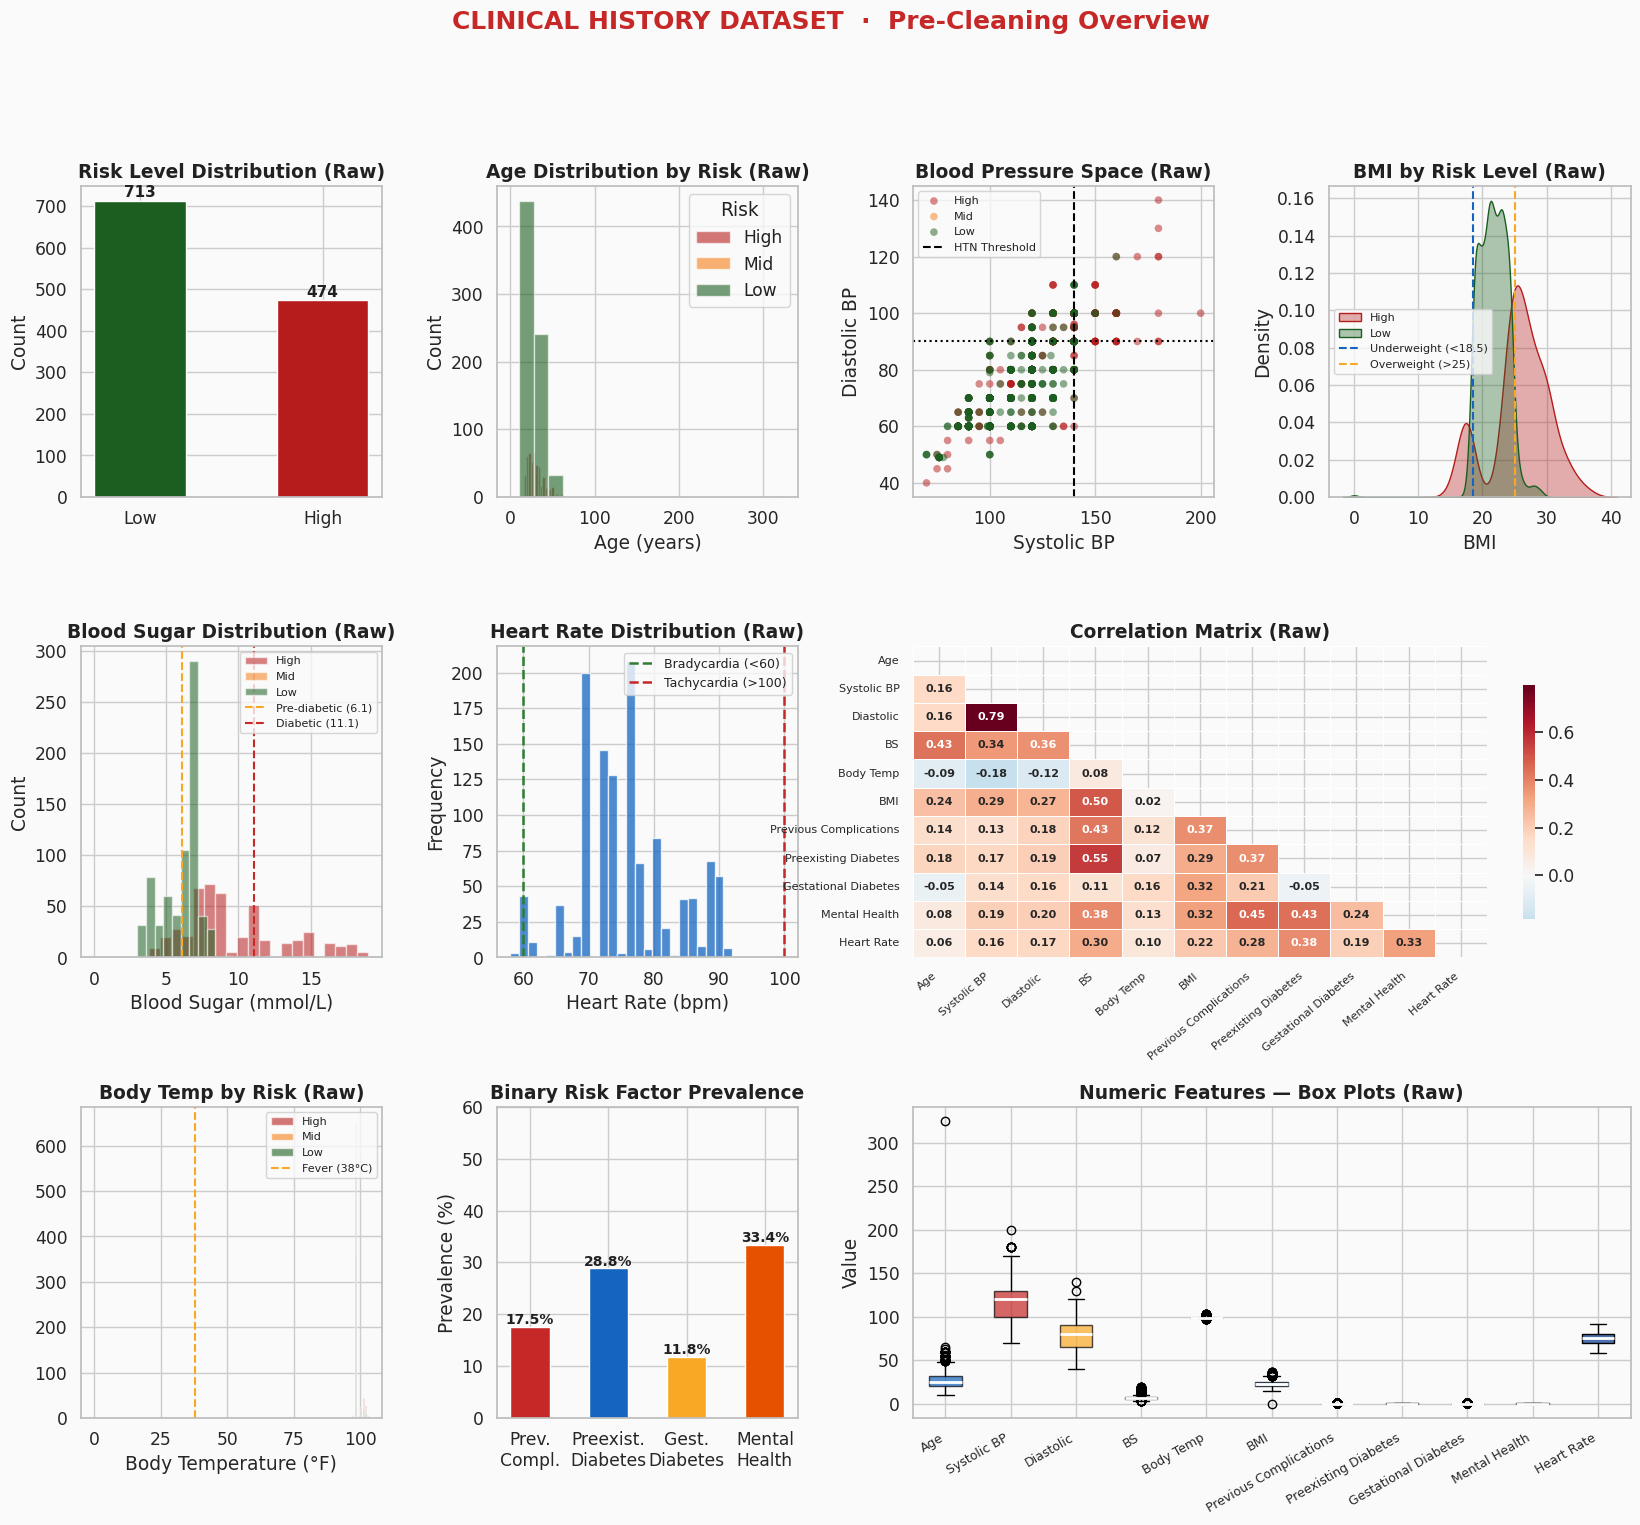


 Saved: clinical_history_pre_cleaning_overview.png


In [27]:
# Pre-cleaning Visualizations

fig = plt.figure(figsize=(20, 16))
fig.patch.set_facecolor(PALETTE['bg'])
gs  = gridspec.GridSpec(3, 4, figure=fig, hspace=0.48, wspace=0.38)

fig.suptitle(
    'CLINICAL HISTORY DATASET  ·  Pre-Cleaning Overview',
    fontsize=18, fontweight='bold', color=PALETTE['primary'], y=0.99
)

# 1: Risk Level distribution
ax1 = fig.add_subplot(gs[0, 0])
rc  = df_raw['Risk Level'].value_counts()
clrs = [RISK_COLORS.get(k, PALETTE['secondary']) for k in rc.index]
ax1.bar(rc.index, rc.values, color=clrs, edgecolor='white', width=0.5)
for i, (v, c) in enumerate(zip(rc.values, clrs)):
    ax1.text(i, v + 8, str(v), ha='center', fontsize=11, fontweight='bold')
ax1.set_title('Risk Level Distribution (Raw)', fontweight='bold')
ax1.set_ylabel('Count')

# 2: Age distribution
ax2 = fig.add_subplot(gs[0, 1])
for risk, clr in RISK_COLORS.items():
    sub = df_raw[df_raw['Risk Level'] == risk]['Age'].dropna()
    ax2.hist(sub, bins=18, alpha=0.6, color=clr, label=risk, edgecolor='white')
ax2.set_xlabel('Age (years)'); ax2.set_ylabel('Count')
ax2.set_title('Age Distribution by Risk (Raw)', fontweight='bold')
ax2.legend(title='Risk')

# 3: Blood pressure scatter
ax3 = fig.add_subplot(gs[0, 2])
for risk, clr in RISK_COLORS.items():
    sub = df_raw[df_raw['Risk Level'] == risk]
    ax3.scatter(sub['Systolic BP'], sub['Diastolic'],
                c=clr, alpha=0.5, s=30, label=risk, edgecolors='none')
ax3.axvline(140, color='black', linestyle='--', linewidth=1.5, label='HTN Threshold')
ax3.axhline(90,  color='black', linestyle=':',  linewidth=1.5)
ax3.set_xlabel('Systolic BP'); ax3.set_ylabel('Diastolic BP')
ax3.set_title('Blood Pressure Space (Raw)', fontweight='bold')
ax3.legend(fontsize=8)

# 4: BMI distribution
ax5 = fig.add_subplot(gs[0, 3])
for risk, clr in RISK_COLORS.items():
    sub = df_raw[df_raw['Risk Level'] == risk]['BMI'].dropna()
    sns.kdeplot(sub, ax=ax5, color=clr, fill=True, alpha=0.35, label=risk)
ax5.axvline(18.5, color=PALETTE['secondary'], linestyle='--', linewidth=1.5, label='Underweight (<18.5)')
ax5.axvline(25.0, color=PALETTE['accent'],    linestyle='--', linewidth=1.5, label='Overweight (>25)')
ax5.set_xlabel('BMI'); ax5.set_title('BMI by Risk Level (Raw)', fontweight='bold')
ax5.legend(fontsize=8)

# 5: Blood Sugar distribution
ax6 = fig.add_subplot(gs[1, 0])
for risk, clr in RISK_COLORS.items():
    sub = df_raw[df_raw['Risk Level'] == risk]['BS'].dropna()
    ax6.hist(sub, bins=20, alpha=0.55, color=clr, label=risk, edgecolor='white')
ax6.axvline(6.1,  color=PALETTE['accent'], linestyle='--', linewidth=1.5, label='Pre-diabetic (6.1)')
ax6.axvline(11.1, color=PALETTE['primary'], linestyle='--', linewidth=1.5, label='Diabetic (11.1)')
ax6.set_xlabel('Blood Sugar (mmol/L)'); ax6.set_ylabel('Count')
ax6.set_title('Blood Sugar Distribution (Raw)', fontweight='bold')
ax6.legend(fontsize=8)

# 6: Heart Rate distribution
ax7 = fig.add_subplot(gs[1, 1])
ax7.hist(df_raw['Heart Rate'].dropna(), bins=25,
         color=PALETTE['secondary'], alpha=0.75, edgecolor='white')
ax7.axvline(60,  color=PALETTE['positive'], linestyle='--', linewidth=1.8, label='Bradycardia (<60)')
ax7.axvline(100, color=PALETTE['primary'],  linestyle='--', linewidth=1.8, label='Tachycardia (>100)')
ax7.set_xlabel('Heart Rate (bpm)'); ax7.set_ylabel('Frequency')
ax7.set_title('Heart Rate Distribution (Raw)', fontweight='bold')
ax7.legend(fontsize=9)

# 7: Correlation matrix
ax8 = fig.add_subplot(gs[1, 2:4])
num_cols = df_raw.select_dtypes(include='number').columns
corr     = df_raw[num_cols].corr()
mask     = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax8, linewidths=0.4,
            annot_kws={'size': 8, 'weight': 'bold'},
            cbar_kws={'shrink': 0.75})
ax8.set_title('Correlation Matrix (Raw)', fontweight='bold')
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=40, ha='right', fontsize=8)
ax8.set_yticklabels(ax8.get_yticklabels(), fontsize=8)

# 8: Body temperature distribution
ax9 = fig.add_subplot(gs[2, 0])
for risk, clr in RISK_COLORS.items():
    sub = df_raw[df_raw['Risk Level'] == risk]['Body Temp'].dropna()
    ax9.hist(sub, bins=15, alpha=0.6, color=clr, label=risk, edgecolor='white')
ax9.axvline(38.0, color=PALETTE['accent'], linestyle='--', linewidth=1.5, label='Fever (38°C)')
ax9.set_xlabel('Body Temperature (°F)')
ax9.set_title('Body Temp by Risk (Raw)', fontweight='bold')
ax9.legend(fontsize=8)

# 9: Binary features breakdown
ax10 = fig.add_subplot(gs[2, 1])
binary_cols = ['Previous Complications', 'Preexisting Diabetes',
               'Gestational Diabetes', 'Mental Health']
binary_rates = [df_raw[c].mean() * 100 for c in binary_cols]
short_names  = ['Prev.\nCompl.', 'Preexist.\nDiabetes', 'Gest.\nDiabetes', 'Mental\nHealth']
bar_colors10 = [PALETTE['primary'], PALETTE['secondary'], PALETTE['accent'], PALETTE['warn']]
ax10.bar(short_names, binary_rates, color=bar_colors10, edgecolor='white', width=0.5)
for i, v in enumerate(binary_rates):
    ax10.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax10.set_ylabel('Prevalence (%)')
ax10.set_title('Binary Risk Factor Prevalence', fontweight='bold')
ax10.set_ylim(0, 60)

# 10: Box plots numeric
ax11 = fig.add_subplot(gs[2, 2:])
data_box  = [df_raw[c].dropna().values for c in num_cols]
bplot     = ax11.boxplot(data_box, patch_artist=True, notch=False, vert=True)
box_clrs  = [PALETTE['secondary'], PALETTE['primary'], PALETTE['accent'],
             PALETTE['positive'], PALETTE['warn'], PALETTE['secondary'], PALETTE['positive']]
for patch, clr in zip(bplot['boxes'], box_clrs):
    patch.set_facecolor(clr); patch.set_alpha(0.7)
for median in bplot['medians']:
    median.set_color('white'); median.set_linewidth(2)
ax11.set_xticklabels(num_cols, rotation=30, ha='right', fontsize=9)
ax11.set_title('Numeric Features — Box Plots (Raw)', fontweight='bold')
ax11.set_ylabel('Value')

plt.savefig(OUTPUT_DIR + 'clinical_history_pre_cleaning_overview.png',
            dpi=150, bbox_inches='tight')

plt.show()

plt.close()
print("\n Saved: clinical_history_pre_cleaning_overview.png")

In [28]:
# Data Cleaning Pipeline

df = df_raw.copy()

# Renaming columns to snake_case
rename_map = {
    'Age':                     'age',
    'Systolic BP':             'systolic_bp',
    'Diastolic':               'diastolic_bp',
    'BS':                      'blood_sugar',
    'Body Temp':               'body_temp_f',
    'BMI':                     'bmi',
    'Previous Complications':  'prev_complications',
    'Preexisting Diabetes':    'preexist_diabetes',
    'Gestational Diabetes':    'gest_diabetes',
    'Mental Health':           'mental_health',
    'Heart Rate':              'heart_rate',
    'Risk Level':              'risk_level',
}
df = df.rename(columns=rename_map)
print(f"Renaming columns     : {list(df.columns)}")

# Handling missing values
null_count = df.isnull().sum().sum()
df = df.dropna()
print(f"Dropping nulls         : {null_count} nulls removed | rows {df.shape[0]}")

# Removing duplicates
dup_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removing duplicates  : {dup_count} removed | rows {df.shape[0]}")

# Clinical range validation
before_outlier = len(df)
valid_mask = (
    (df['age'].between(10, 65))       &   # maternal age range
    (df['systolic_bp'].between(50, 200)) &
    (df['diastolic_bp'].between(30, 150)) &
    (df['blood_sugar'].between(3.0, 30.0)) &
    (df['body_temp_f'].between(95, 104))  &
    (df['bmi'].between(10, 60))           &
    (df['heart_rate'].between(30, 200))
)
df = df[valid_mask].reset_index(drop=True)
outliers_removed = before_outlier - len(df)
print("Outlier removal    : {outliers_removed} rows removed | rows {df.shape[0]}")

# Derived clinical features
df['pulse_pressure']    = df['systolic_bp'] - df['diastolic_bp']
df['map_mmhg']          = df['diastolic_bp'] + df['pulse_pressure'] / 3  # Mean Arterial Pressure
df['temp_celsius']      = (df['body_temp_f'] - 32) * 5 / 9
df['hypertension_flag'] = ((df['systolic_bp'] >= 140) | (df['diastolic_bp'] >= 90)).astype(int)
df['diabetes_any']      = ((df['preexist_diabetes'] == 1) | (df['gest_diabetes'] == 1)).astype(int)
df['high_risk_score']   = (
    df['hypertension_flag'] +
    df['diabetes_any'] +
    df['prev_complications'] +
    df['mental_health'] +
    (df['blood_sugar'] > 11.1).astype(int)
)
print(f"Derived features   : pulse_pressure, MAP, temp_celsius, hypertension_flag, diabetes_any, high_risk_score")

# Encoding target
le = LabelEncoder()
df['risk_encoded'] = le.fit_transform(df['risk_level'])
print(f"Encode target      : {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Normalising numeric features (for MLP branch)
scaler = StandardScaler()
numeric_feats = ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar',
                 'body_temp_f', 'bmi', 'heart_rate', 'pulse_pressure', 'map_mmhg']
df_scaled = df.copy()
df_scaled[numeric_feats] = scaler.fit_transform(df[numeric_feats])
print(f"Scaled features    : {numeric_feats}")

print(f"CLEANED DATASET SUMMARY")
print(f"Shape   : {df.shape}")
print(f"Columns : {list(df.columns)}")
print(f"\n{df.describe().round(3)}")

Renaming columns     : ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp_f', 'bmi', 'prev_complications', 'preexist_diabetes', 'gest_diabetes', 'mental_health', 'heart_rate', 'risk_level']
Dropping nulls         : 53 nulls removed | rows 1166
Removing duplicates  : 18 removed | rows 1148
Outlier removal    : {outliers_removed} rows removed | rows {df.shape[0]}
Derived features   : pulse_pressure, MAP, temp_celsius, hypertension_flag, diabetes_any, high_risk_score
Encode target      : {'High': np.int64(0), 'Low': np.int64(1)}
Scaled features    : ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp_f', 'bmi', 'heart_rate', 'pulse_pressure', 'map_mmhg']
CLEANED DATASET SUMMARY
Shape   : (1146, 19)
Columns : ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp_f', 'bmi', 'prev_complications', 'preexist_diabetes', 'gest_diabetes', 'mental_health', 'heart_rate', 'risk_level', 'pulse_pressure', 'map_mmhg', 'temp_celsius', 'hypertension_flag', 'diabetes_

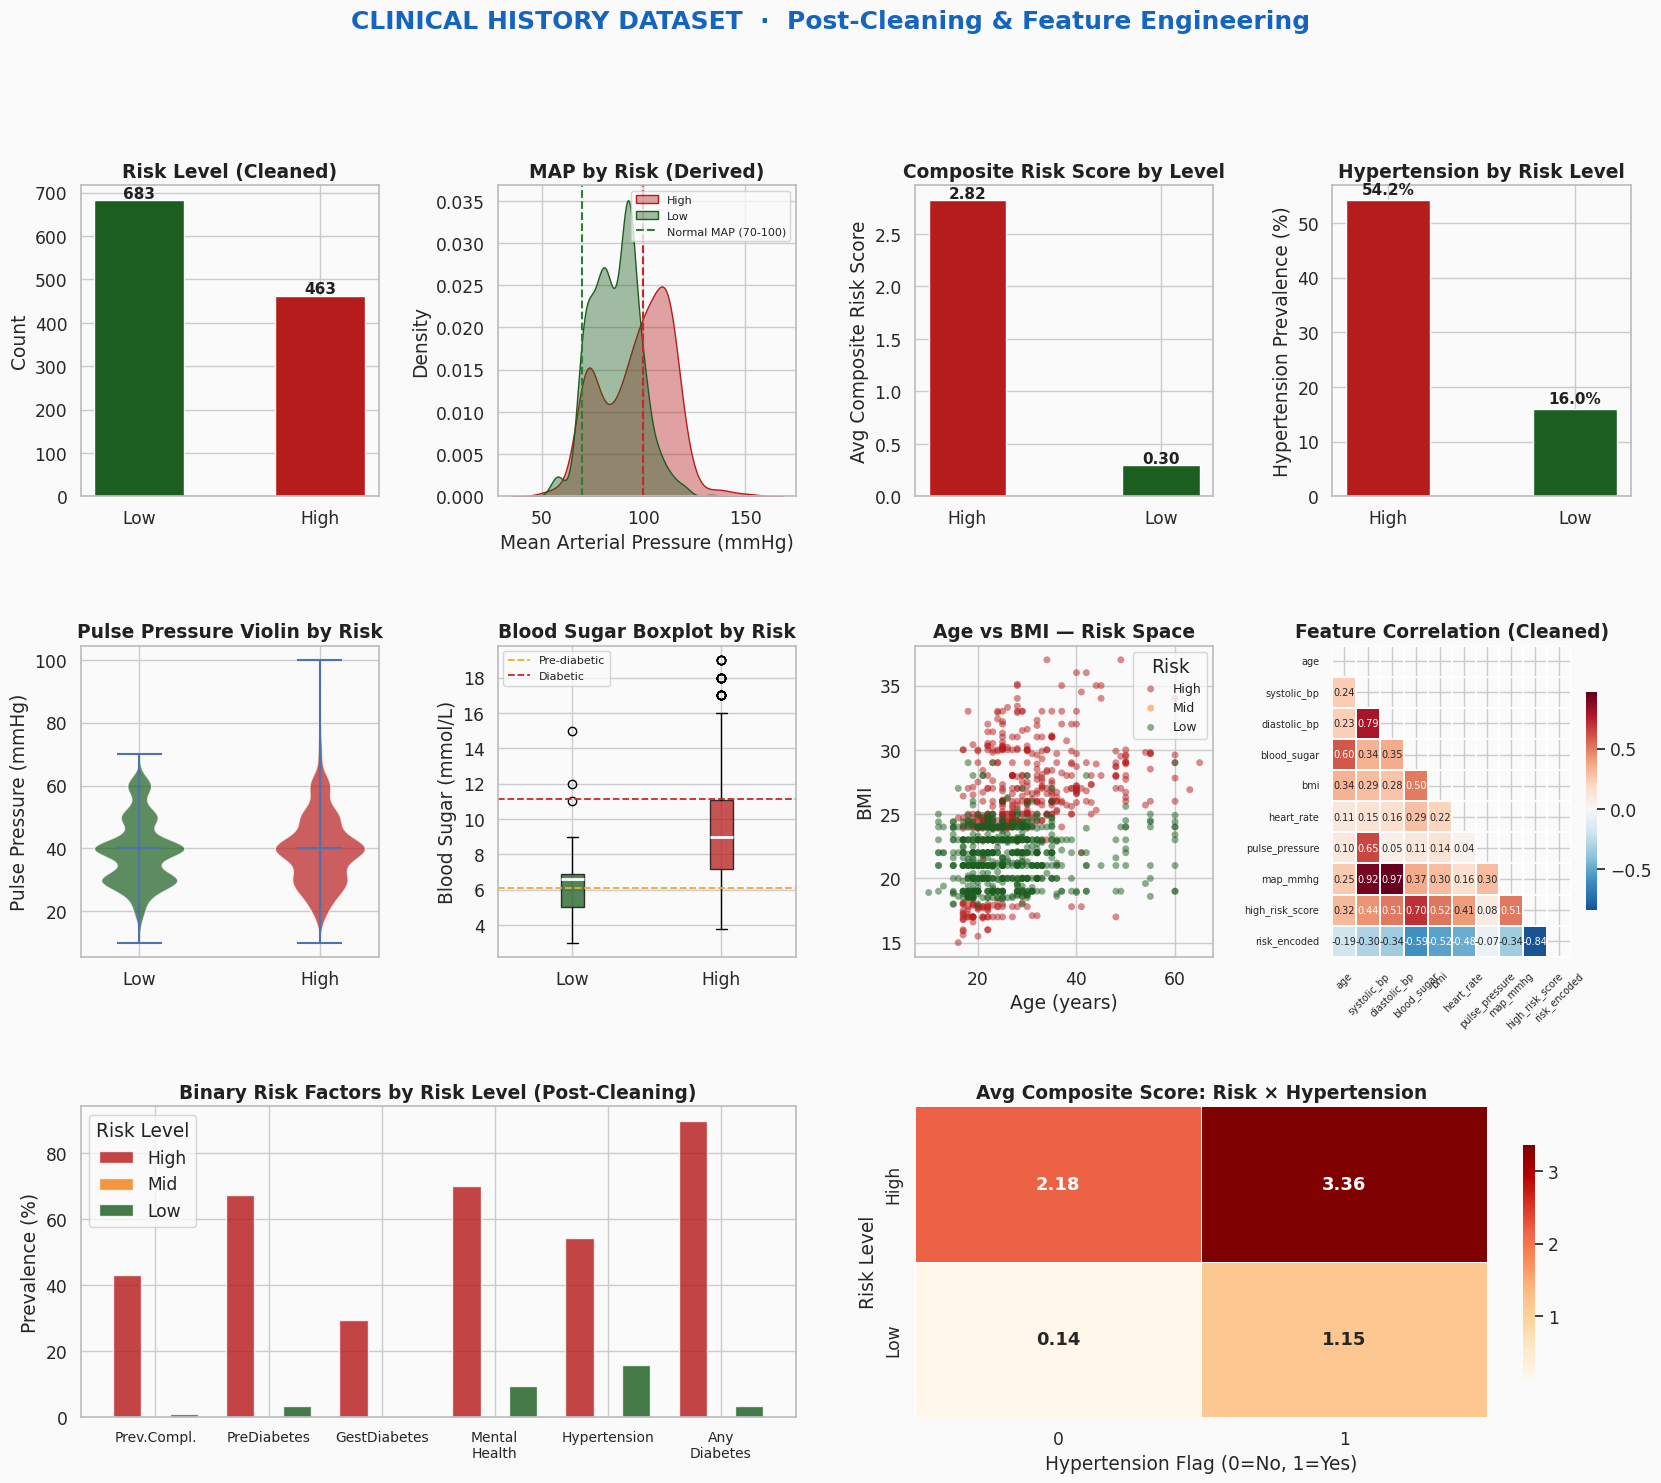

Saved: clinical_history_post_cleaning_features.png


In [29]:
# Post-Cleaning Visualisations
fig2 = plt.figure(figsize=(20, 16))
fig2.patch.set_facecolor(PALETTE['bg'])
gs2  = gridspec.GridSpec(3, 4, figure=fig2, hspace=0.48, wspace=0.4)

fig2.suptitle(
    'CLINICAL HISTORY DATASET  ·  Post-Cleaning & Feature Engineering',
    fontsize=18, fontweight='bold', color=PALETTE['secondary'], y=0.99
)

# 1: Risk balance (cleaned)
ax1 = fig2.add_subplot(gs2[0, 0])
rc2 = df['risk_level'].value_counts()
ax1.bar(rc2.index, rc2.values,
        color=[RISK_COLORS.get(k, PALETTE['secondary']) for k in rc2.index],
        edgecolor='white', width=0.5)
for i, v in enumerate(rc2.values):
    ax1.text(i, v + 5, str(v), ha='center', fontsize=11, fontweight='bold')
ax1.set_title('Risk Level (Cleaned)', fontweight='bold')
ax1.set_ylabel('Count')

# 2: Mean Arterial Pressure by risk
ax2 = fig2.add_subplot(gs2[0, 1])
for risk, clr in RISK_COLORS.items():
    sub = df[df['risk_level'] == risk]['map_mmhg'].dropna()
    sns.kdeplot(sub, ax=ax2, color=clr, fill=True, alpha=0.4, label=risk)
ax2.axvline(70,  color=PALETTE['positive'], linestyle='--', linewidth=1.5, label='Normal MAP (70-100)')
ax2.axvline(100, color=PALETTE['primary'],  linestyle='--', linewidth=1.5)
ax2.set_xlabel('Mean Arterial Pressure (mmHg)')
ax2.set_title('MAP by Risk (Derived)', fontweight='bold')
ax2.legend(fontsize=8)

# 3: High Risk Score distribution
ax3 = fig2.add_subplot(gs2[0, 2])
score_by_risk = df.groupby('risk_level')['high_risk_score'].mean()
bar_clrs3 = [RISK_COLORS.get(k, PALETTE['secondary']) for k in score_by_risk.index]
ax3.bar(score_by_risk.index, score_by_risk.values, color=bar_clrs3, edgecolor='white', width=0.4)
for i, v in enumerate(score_by_risk.values):
    ax3.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=11, fontweight='bold')
ax3.set_ylabel('Avg Composite Risk Score')
ax3.set_title('Composite Risk Score by Level', fontweight='bold')

# 4: Hypertension prevalence
ax4 = fig2.add_subplot(gs2[0, 3])
htn = df.groupby('risk_level')['hypertension_flag'].mean() * 100
bar_clrs4 = [RISK_COLORS.get(k, PALETTE['secondary']) for k in htn.index]
ax4.bar(htn.index, htn.values, color=bar_clrs4, edgecolor='white', width=0.45)
for i, v in enumerate(htn.values):
    ax4.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')
ax4.set_ylabel('Hypertension Prevalence (%)')
ax4.set_title('Hypertension by Risk Level', fontweight='bold')

# 5: Pulse pressure violin
ax5 = fig2.add_subplot(gs2[1, 0])
actual_risks = df['risk_level'].unique().tolist()
risk_order   = [r for r in ['Low', 'Mid', 'High'] if r in actual_risks]
data_violin  = [df[df['risk_level'] == r]['pulse_pressure'].dropna() for r in risk_order]
data_violin  = [d for d in data_violin if len(d) > 1]   # filter empty
positions    = list(range(1, len(data_violin) + 1))
parts = ax5.violinplot(data_violin, positions=positions, showmedians=True)
violin_clrs = [PALETTE[r.lower()] for r in risk_order[:len(data_violin)]]
for pc, clr in zip(parts['bodies'], violin_clrs):
    pc.set_facecolor(clr); pc.set_alpha(0.7)
ax5.set_xticks(positions); ax5.set_xticklabels(risk_order[:len(data_violin)])
ax5.set_ylabel('Pulse Pressure (mmHg)')
ax5.set_title('Pulse Pressure Violin by Risk', fontweight='bold')

# 6: Blood sugar boxplot
ax6 = fig2.add_subplot(gs2[1, 1])
risk_colors_local = {'Low': PALETTE['low'], 'Mid': PALETTE['mid'], 'High': PALETTE['high']}
data_bs = [df[df['risk_level'] == r]['blood_sugar'].dropna() for r in risk_order]
data_bs = [d for d in data_bs if len(d) > 1]
bplot6  = ax6.boxplot(data_bs, patch_artist=True, notch=False)
for patch, r in zip(bplot6['boxes'], risk_order[:len(data_bs)]):
    patch.set_facecolor(risk_colors_local.get(r, PALETTE['secondary'])); patch.set_alpha(0.75)
for med in bplot6['medians']:
    med.set_color('white'); med.set_linewidth(2)
ax6.set_xticklabels(risk_order)
ax6.set_ylabel('Blood Sugar (mmol/L)')
ax6.axhline(6.1,  color=PALETTE['accent'], linestyle='--', linewidth=1.3, label='Pre-diabetic')
ax6.axhline(11.1, color=PALETTE['primary'], linestyle='--', linewidth=1.3, label='Diabetic')
ax6.legend(fontsize=8)
ax6.set_title('Blood Sugar Boxplot by Risk', fontweight='bold')

# 7: Age vs BMI scatter
ax7 = fig2.add_subplot(gs2[1, 2])
for risk, clr in RISK_COLORS.items():
    sub = df[df['risk_level'] == risk]
    ax7.scatter(sub['age'], sub['bmi'], c=clr, alpha=0.5, s=25, label=risk, edgecolors='none')
ax7.set_xlabel('Age (years)'); ax7.set_ylabel('BMI')
ax7.set_title('Age vs BMI — Risk Space', fontweight='bold')
ax7.legend(title='Risk', fontsize=9)

# 8: Feature correlation heatmap (cleaned)
ax8 = fig2.add_subplot(gs2[1, 3])
feat_corr = df[['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar',
                 'bmi', 'heart_rate', 'pulse_pressure', 'map_mmhg',
                 'high_risk_score', 'risk_encoded']].corr()
mask8 = np.triu(np.ones_like(feat_corr, dtype=bool))
sns.heatmap(feat_corr, mask=mask8, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax8, linewidths=0.3,
            annot_kws={'size': 7},
            cbar_kws={'shrink': 0.7})
ax8.set_title('Feature Correlation (Cleaned)', fontweight='bold')
ax8.tick_params(axis='x', rotation=45, labelsize=7)
ax8.tick_params(axis='y', rotation=0,  labelsize=7)

# 9: Binary features by risk
ax9 = fig2.add_subplot(gs2[2, :2])
bin_feats = ['prev_complications', 'preexist_diabetes', 'gest_diabetes',
             'mental_health', 'hypertension_flag', 'diabetes_any']
bin_names = ['Prev.Compl.', 'PreDiabetes', 'GestDiabetes', 'Mental\nHealth', 'Hypertension', 'Any\nDiabetes']
x9  = np.arange(len(bin_feats))
w9  = 0.25
for i, (risk, clr) in enumerate(RISK_COLORS.items()):
    rates = [df[df['risk_level'] == risk][f].mean() * 100 for f in bin_feats]
    ax9.bar(x9 + i * w9, rates, w9, label=risk, color=clr, alpha=0.82, edgecolor='white')
ax9.set_xticks(x9 + w9); ax9.set_xticklabels(bin_names, fontsize=10)
ax9.set_ylabel('Prevalence (%)')
ax9.set_title('Binary Risk Factors by Risk Level (Post-Cleaning)', fontweight='bold')
ax9.legend(title='Risk Level')

# 10: Composite risk score heatmap
ax10 = fig2.add_subplot(gs2[2, 2:])
pivot = df.pivot_table(values='high_risk_score', index='risk_level',
                       columns='hypertension_flag', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='OrRd', ax=ax10,
            linewidths=0.5, cbar_kws={'shrink': 0.75},
            annot_kws={'size': 13, 'weight': 'bold'})
ax10.set_xlabel('Hypertension Flag (0=No, 1=Yes)')
ax10.set_ylabel('Risk Level')
ax10.set_title('Avg Composite Score: Risk × Hypertension', fontweight='bold')

plt.savefig(OUTPUT_DIR + 'clinical_history_post_cleaning_features.png',
            dpi=150, bbox_inches='tight')

plt.show()
plt.close()
print("Saved: clinical_history_post_cleaning_features.png")

## Dropping Risk Level Column

The 'risk_level' column was kept throughout EDA and post-cleaning visualisations so we could understand the data. It is now removed before the file is saved for model training.

Reason: In the Ruvimbo PPH multimodal fusion system, risk is an EMERGENT property of all three modalities combined. The clinical history branch is trained using an auxiliary multi-label task (hypertension / diabetes / complications flags), which is NOT a risk label. Using risk_level for training would:  

(a) introduce label leakage into the fusion pipeline 

(b) anchor the branch to a single-source risk definition that ignores anemia severity and PPG signals

The risk_level column remains in the raw CSV for reference.

In [ ]:
# DROPPING risk_level before saving

risk_dist_before_drop = df['risk_level'].value_counts().to_dict()
df_for_training = df.drop(columns=['risk_level', 'risk_encoded'], errors='ignore')
print(f"\nDrop risk_level (EDA only, not for training)")
print(f"  risk_level distribution was : {risk_dist_before_drop}")
print(f"  Columns saved for training  : {list(df_for_training.columns)}")
print(f"  risk_level status           : EXCLUDED from processed file")

df_for_training.to_csv(CLEANED_OUT, index=False)
print(f"\nSaved (no risk label) → {CLEANED_OUT}")


Drop risk_level (EDA only, not for training)
  risk_level distribution was : {'Low': 683, 'High': 463}
  Columns saved for training  : ['age', 'systolic_bp', 'diastolic_bp', 'blood_sugar', 'body_temp_f', 'bmi', 'prev_complications', 'preexist_diabetes', 'gest_diabetes', 'mental_health', 'heart_rate', 'pulse_pressure', 'map_mmhg', 'temp_celsius', 'hypertension_flag', 'diabetes_any', 'high_risk_score']
  risk_level status           : EXCLUDED from processed file

Saved (no risk label) → ../data/processed/clinical_history_cleaned.csv


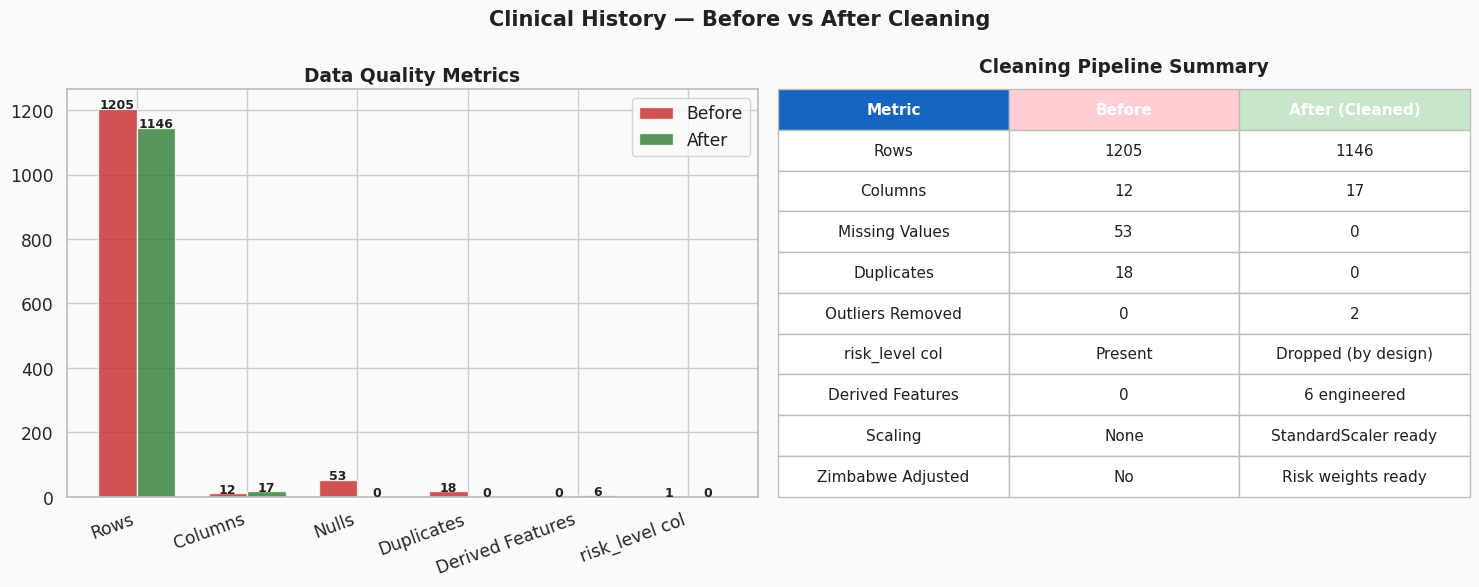

Saved: clinical_history_before_after_summary.png
Clinical History EDA & Cleaning done


In [34]:
# BEFORE vs AFTER Summary Panel
fig3, axes3 = plt.subplots(1, 2, figsize=(15, 6))
fig3.patch.set_facecolor(PALETTE['bg'])
fig3.suptitle('Clinical History — Before vs After Cleaning',
              fontsize=15, fontweight='bold')

# Left: bar comparison
metrics_b = {'Rows': len(df_raw), 'Columns': df_raw.shape[1],
             'Nulls': df_raw.isnull().sum().sum(), 'Duplicates': df_raw.duplicated().sum(),
             'Derived Features': 0, 'risk_level col': 1}
metrics_a = {'Rows': len(df_for_training), 'Columns': df_for_training.shape[1],
             'Nulls': 0, 'Duplicates': 0,
             'Derived Features': 6, 'risk_level col': 0}
x3 = np.arange(len(metrics_b)); w3 = 0.35
ax_lb = axes3[0]
b1 = ax_lb.bar(x3 - w3/2, list(metrics_b.values()), w3, label='Before', color=PALETTE['primary'], alpha=0.8, edgecolor='white')
b2 = ax_lb.bar(x3 + w3/2, list(metrics_a.values()), w3, label='After',  color=PALETTE['positive'], alpha=0.8, edgecolor='white')
ax_lb.set_xticks(x3)
ax_lb.set_xticklabels(list(metrics_b.keys()), rotation=20, ha='right')
ax_lb.set_title('Data Quality Metrics', fontweight='bold')
ax_lb.legend()
for bar in list(b1) + list(b2):
    ax_lb.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
               str(int(bar.get_height())), ha='center', fontsize=9, fontweight='bold')

# Right: Table
table_rows = [
    ['Metric',              'Before',         'After (Cleaned)'],
    ['Rows',                '1205',           str(len(df_for_training))],
    ['Columns',             '12',             str(df_for_training.shape[1])],
    ['Missing Values',      str(df_raw.isnull().sum().sum()), '0'],
    ['Duplicates',          str(df_raw.duplicated().sum()),   '0'],
    ['Outliers Removed',    '0',             str(outliers_removed)],
    ['risk_level col',      'Present',        'Dropped (by design)'],
    ['Derived Features',    '0',              '6 engineered'],
    ['Scaling',             'None',           'StandardScaler ready'],
    ['Zimbabwe Adjusted',   'No',             'Risk weights ready'],
]
axes3[1].axis('off')
tbl3 = axes3[1].table(
    cellText=table_rows[1:], colLabels=table_rows[0],
    cellLoc='center', loc='center',
    colColours=[PALETTE['secondary'], '#FFCDD2', '#C8E6C9'],
    bbox=[0.0, 0.0, 1.0, 1.0]
)
tbl3.auto_set_font_size(False); tbl3.set_fontsize(11)
for key, cell in tbl3.get_celld().items():
    cell.set_edgecolor('#BDBDBD')
    if key[0] == 0:
        cell.set_text_props(color='white', fontweight='bold')
axes3[1].set_title('Cleaning Pipeline Summary', fontweight='bold', pad=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'clinical_history_before_after_summary.png',
            dpi=150, bbox_inches='tight')

plt.show()
plt.close()
print("Saved: clinical_history_before_after_summary.png")
print("Clinical History EDA & Cleaning done")